
___
# Conducting a Parameter Estimation
___

Author: Savannah Sakhai, Chenyu Wang

For this demonstration, we will be going through how to set up a parameter estimation using the Pyomo tool ***parmest***. This simple case study aims to develop an empirical equation for the vapor pressure of an NaCl solution over a range of temperature and salt mass fractions.

### Step 0: Imports

In [1]:
import pandas as pd # to create a pandas dataframe to organize the data
import numpy as np # to manipulate the data into a usable format
import pyomo.contrib.parmest.parmest as parmest # to perform the parameter estimation
import pyomo.environ as pyo # to create a pyomo model
from pyomo.contrib.parmest.experiment import Experiment
import matplotlib.pyplot as plt # to plot the results
from watertap.core.solvers import get_solver # to bring in ipopt solver
solver = get_solver() # this will make the ipopt solver available

### Step 1: Gather the data

In [2]:
# data obtained using PhreeqC
# read in csv file to pd.dataframe
data = pd.read_csv(
    'P_sat_Data.csv',
    header=None,
)

display(data)

0         1          2          3          4          5   \
0          NaN  5.000000  10.000000  20.000000  30.000000  40.000000   
1    35.000000  0.008548   0.011981   0.022664   0.040939   0.070926   
2    51.071429  0.008447   0.011838   0.022391   0.040441   0.070058   
3    67.142857  0.008344   0.011692   0.022111   0.039930   0.069167   
4    83.214286  0.008238   0.011543   0.021823   0.039404   0.068249   
5    99.285714  0.008130   0.011389   0.021527   0.038862   0.067304   
6   115.357143  0.008018   0.011230   0.021221   0.038305   0.066332   
7   131.428571  0.007902   0.011066   0.020906   0.037731   0.065333   
8   147.500000  0.007782   0.010896   0.020582   0.037140   0.064307   
9   163.571429  0.007658   0.010722   0.020247   0.036533   0.063254   
10  179.642857  0.007530   0.010541   0.019903   0.035911   0.062177   
11  195.714286  0.007398   0.010355   0.019550   0.035273   0.061076   
12  211.785714  0.007261   0.010163   0.019187   0.034620   0.059952   
13  227.857143  0.007120   0.009965   0.018815   0.033953   0.058808   
14  243.928571  0.006975   0.009762   0.018434   0.033273   0.057645   
15  260.000000  0.006825   0.009554   0.018045   0.032581   0.056464   

           6          7          8          9          10          11  \
0   50.000000  60.000000  70.000000  80.000000  90.000000  100.000000   
1    0.118314   0.190684   0.297821   0.451976   0.668080    0.963854   
2    0.116862   0.188342   0.294164   0.446437   0.659918    0.952128   
3    0.115369   0.185932   0.290401   0.440739   0.651523    0.940072   
4    0.113832   0.183451   0.286529   0.434876   0.642891    0.927682   
5    0.112250   0.180900   0.282549   0.428853   0.634026    0.914965   
6    0.110624   0.178278   0.278462   0.422673   0.624938    0.901938   
7    0.108954   0.175590   0.274275   0.416347   0.615642    0.888625   
8    0.107242   0.172836   0.269992   0.409884   0.606156    0.875051   
9    0.105490   0.170023   0.265622   0.403297   0.596498    0.861246   
10   0.103699   0.167153   0.261172   0.396599   0.586691    0.847243   
11   0.101874   0.164233   0.256650   0.389805   0.576755    0.833075   
12   0.100015   0.161267   0.252067   0.382928   0.566714    0.818775   
13   0.098128   0.158260   0.247430   0.375984   0.556590    0.804376   
14   0.096214   0.155219   0.242749   0.368986   0.546405    0.789912   
15   0.094276   0.152148   0.238034   0.361950   0.536181    0.775415   

            12          13          14          15          16  
0   110.000000  120.000000  130.000000  140.000000  150.000000  
1     1.360139    1.880266    2.550230    3.398336    4.454784  
2     1.343665    1.857625    2.519725    3.357989    4.402328  
3     1.326736    1.834374    2.488425    3.316629    4.348612  
4     1.309348    1.810509    2.456323    3.274245    4.293618  
5     1.291514    1.786050    2.423446    3.230873    4.237388  
6     1.273260    1.761033    2.389844    3.186577    4.180008  
7     1.254618    1.735505    2.355583    3.141449    4.121594  
8     1.235629    1.709523    2.320741    3.095592    4.062284  
9     1.216337    1.683151    2.285405    3.049123    4.002229  
10    1.196788    1.656453    2.249666    3.002163    3.941589  
11    1.177031    1.629498    2.213617    2.954839    3.880529  
12    1.157114    1.602354    2.177352    2.907276    3.819216  
13    1.137085    1.575091    2.140966    2.859600    3.757814  
14    1.116993    1.547774    2.104549    2.811934    3.696485  
15    1.096885    1.520470    2.068193    2.764399    3.635388


### Step 2: Prepare the data
*How does parmest need the data to be formatted?*


- **Pandas Dataframe:** each column is an observed quantity (temperature, concentration, vapor pressure, etc.), each row is a distinct scenario (25, 0.02, 31.33)

**Other options:**
- **List of Pandas Dataframe:** each entry of the list is a distinct scenario, each dataframe an observed quantity
- **List of dictionaries:** each entry of the list is a distinct scenario, each key an observed quantity 
- **List of json file names:** each entry of the list contains a json file with the distinct scenario (for large datasets in parallel computing)

In [3]:
def get_formatted_data(data):
    # convert dataframe to numpy array for the manipulations
    npdata = data.to_numpy()

    # obtain input variables (salt g/kg water, temperature C)
    c = npdata[1:, 0]
    T = npdata[0, 1:]

    # repeat each value of temperature for the number of mass fraction entries
    T_col = np.repeat(T, len(c)).T +273 #celsius to kelvin

    # repeat the set of mass fraction entries for the number of temperature entries
    c_col = np.tile(c, len(T)).T /1000  #g/kg water to mass frac 

    # take the output table and create a column
    output_data = npdata[1:, 1:].T.reshape(-1) * 101325 #atm to Pa

    # compile into one table where each column is a different observed quantity
    total_data = np.column_stack([c_col, T_col, output_data])

    # redefine as a pandas dataframe with named columns
    data = pd.DataFrame(total_data,
                        columns=['Comp', 'Temp', 'PropData'],
                        )

    # delete all rows when column 'PropData' has a value of 0 (scenarios without measured property data)
    index_NA = data[(data['PropData'] == 0)].index
    data.drop(index_NA, inplace=True)

    return data
    

In [12]:
data_formatted = get_formatted_data(data) 
print(data_formatted)
# print(data_formatted.to_markdown())

         Comp   Temp       PropData
0    0.035000  278.0     866.078781
1    0.051071  278.0     855.860864
2    0.067143  278.0     845.433914
3    0.083214  278.0     834.740479
4    0.099286  278.0     823.734861
..        ...    ...            ...
235  0.195714  423.0  393194.608930
236  0.211786  423.0  386982.037389
237  0.227857  423.0  380760.491594
238  0.243929  423.0  374546.383155
239  0.260000  423.0  368355.661236

[240 rows x 3 columns]


### Step 3: Propose a model
*What equation are parameters being fit to?*

***Parmest*** requires a "model function" to be defined that takes in the data and returns a Pyomo model.

Set up the Pyomo model defining:
- Pyomo Vars or Params for input variables, output variables and parameters to be estimated
- the model equation (a function of the observed data, i.e. mass fraction and temprature)

For this example, the model we are proposing is:
$$
y = (a_0 + a_1*x + a_2*x^2 + a_3*x^3+ a_4*x^4)
$$
$$
+ (b_0 + b_1*x + b_2*x^2 + b_3*x^3+ b_4*x^4)*T
$$
$$
+ (c_0 + c_1*x + c_2*x^2 + c_3*x^3+ c_4*x^4)*T^2
$$
$$
+ (d_0 + d_1*x + d_2*x^2 + d_3*x^3+ d_4*x^4)*T^3
$$
$$
+ (e_0 + e_1*x + e_2*x^2 + e_3*x^3 + e_4*x^4)*T^4 
$$
where $y$ is the output variables, $x$ (mass fraction) and $T$ (temperature) are the input variables, and $a_0$ to $e_4$ are parameters to be estimated

*(This was an equation found in [literature](https://www.sciencedirect.com/science/article/pii/S0011916403900683) used when fitting Pitzer NaCl Data).*

In [5]:
def model_function():
    m = pyo.ConcreteModel()

    # initialize values for the estimated parameters
    m.a0 = pyo.Param(initialize=1, mutable=True)
    m.a1 = pyo.Param(initialize=1, mutable=True)
    m.a2 = pyo.Param(initialize=1, mutable=True)
    m.a3 = pyo.Param(initialize=1, mutable=True)
    m.a4 = pyo.Param(initialize=1, mutable=True)

    m.b0 = pyo.Param(initialize=1, mutable=True)
    m.b1 = pyo.Param(initialize=1, mutable=True)
    m.b2 = pyo.Param(initialize=1, mutable=True)
    m.b3 = pyo.Param(initialize=1, mutable=True)
    m.b4 = pyo.Param(initialize=1, mutable=True)

    m.c0 = pyo.Param(initialize=1, mutable=True)
    m.c1 = pyo.Param(initialize=1, mutable=True)
    m.c2 = pyo.Param(initialize=1, mutable=True)
    m.c3 = pyo.Param(initialize=1, mutable=True)
    m.c4 = pyo.Param(initialize=1, mutable=True)

    m.d0 = pyo.Param(initialize=1, mutable=True)
    m.d1 = pyo.Param(initialize=1, mutable=True)
    m.d2 = pyo.Param(initialize=1, mutable=True)
    m.d3 = pyo.Param(initialize=1, mutable=True)
    m.d4 = pyo.Param(initialize=1, mutable=True)

    m.e0 = pyo.Param(initialize=1, mutable=True)
    m.e1 = pyo.Param(initialize=1, mutable=True)
    m.e2 = pyo.Param(initialize=1, mutable=True)
    m.e3 = pyo.Param(initialize=1, mutable=True)
    m.e4 = pyo.Param(initialize=1, mutable=True)

    # define mass fraction as an input parameter
    m.x = pyo.Param(initialize=0.1, mutable=True)

    # define temperature as an input parameter
    m.T = pyo.Param(initialize=278, mutable=True)

    # define output observation as a variable
    m.y = pyo.Var(initialize=10000)

    # define constraints for the model
    m.prop_rule = pyo.Constraint(
        expr=(
            m.y == ((m.a0 + m.a1*m.x + m.a2*m.x**2 + m.a3*m.x**3+ m.a4*m.x**4) 
                    + (m.b0 + m.b1*m.x + m.b2*m.x**2 + m.b3*m.x**3+ m.b4*m.x**4)*m.T
                    + (m.c0 + m.c1*m.x + m.c2*m.x**2 + m.c3*m.x**3+ m.c4*m.x**4)*m.T**2
                    + (m.d0 + m.d1*m.x + m.d2*m.x**2 + m.d3*m.x**3+ m.d4*m.x**4)*m.T**3
                    + (m.e0 + m.e1 * m.x + m.e2 * m.x ** 2 + m.e3 * m.x ** 3 + m.e4 * m.x ** 4) * m.T ** 4
                   )
        )
    )
    
    return m


### Step 4: Define list of experiment objects
We need to define a list of experiment objects which is used to create one labeled model for each experiment. The template ``Experiment`` can be used to generate a list of experiment objects.

A labeled Pyomo model $m$ has two additional suffixes (Pyomo Suffix):

- ``m.experiment_outputs`` defines experiment outputs (Pyomo Param, Var, or Expression) and their associated data values (float, int).

- ``m.unknown_parameters`` defines the mutable parameters or variables (Pyomo Param or Var) to estimate along with their component unique identifier (Pyomo ComponentUID).

In the experiment class, ``get_labeled_model`` returns the labeled Pyomo model mapping model variables to the data.

In [6]:
class DesignExperiment(Experiment):

    def __init__(self, data, experiment_number):
        self.data = data
        self.experiment_number = experiment_number
        self.data_i = data.loc[experiment_number, :]
        self.model = None

    def create_model(self):
        self.model = m = model_function()
        return m

    def finalize_model(self):
        m = self.model

        # Experiment input values
        m.x = self.data_i['Comp']
        m.T = self.data_i['Temp']

        # Experiment output values
        m.y = self.data_i['PropData']

        return m

    def label_model(self):
        m = self.model

        m.experiment_outputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.experiment_outputs.update([(m.y, self.data_i['PropData'])])

        m.unknown_parameters = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        parameter_set = [m.a0, m.a1, m.a2, m.a3, m.a4, 
                         m.b0, m.b1, m.b2, m.b3, m.b4, 
                         m.c0, m.c1, m.c2, m.c3, m.c4,
                         m.d0, m.d1, m.d2, m.d3, m.d4,
                         m.e0, m.e1, m.e2, m.e3, m.e4]
        m.unknown_parameters.update(
            (k, pyo.ComponentUID(k)) for k in parameter_set
        )

        return m

    def get_labeled_model(self):
        m = self.create_model()
        m = self.finalize_model()
        m = self.label_model()

        return m

### Step 5: Solve the parameter estimation problem

Now, we need to define the following items for parmest to solve the parameter estimation problem: 

    - exp_list
    - objective_function


#### Step 5a: Set up the experimental list

Set up the experimental list by appending the object in the ``Design Experiment`` to a list

In [7]:
# create a experiment list
exp_list = []
for i in range(data_formatted.shape[0]):
    exp_list.append(DesignExperiment(data_formatted, i))

#### Step 5b: Define an objective function

Now, we should define an objective function for the parameter estimation. This is the deviation between the observation and the prediction typically chosen to be the sum of squared errors.

$$
\sum_{i=0}^n (observation_i - prediction_i)^2 
$$

We can use the built-in objective function in Parmest to compute the sum of squared errors (``“SSE”``) between the ``m.experiment_outputs`` model values and data values.

#### Step 5c: Set up the problem

Set up the parameter estimation problem by creating an instance of the parmest ``Estimator`` object and feed it the required inputs.

In [8]:
# create an instance of the parmest estimator  
pest = parmest.Estimator(exp_list, obj_function='SSE')

#### Step 5d: Solve the parameter estimation problem 

Solve the parameter estimation problem by calling ``theta_est``. This will use the entire data set to perform the parameter estimation. 

There are additional options for solving and testing. Further details can be found in the [parmest documentation](https://pyomo.readthedocs.io/en/6.8.0/contributed_packages/parmest/index.html).

In [9]:
# solve the parameter estimation problem
obj, theta = pest.theta_est()
theta = theta.sort_index()
print('theta:\n', theta)

theta:
 a0    8.091276e+06
a1   -4.525386e+06
a2    4.636278e+06
a3   -1.523686e+07
a4    3.185071e+07
b0   -1.097568e+05
b1    6.237745e+04
b2   -4.915034e+04
b3    1.780470e+05
b4   -4.034092e+05
c0    5.616476e+02
c1   -3.243433e+02
c2    1.812158e+02
c3   -7.674163e+02
c4    1.919645e+03
d0   -1.286400e+00
d1    7.547499e-01
d2   -2.559045e-01
d3    1.440655e+00
d4   -4.074548e+00
e0    1.114049e-03
e1   -6.639097e-04
e2    8.724007e-05
e3   -9.891031e-04
e4    3.262410e-03
dtype: float64


### Step 6: Plot results

Finally, we can visualize the results using ***matplotlib*** to create a 3D plot of the data and the parameter estimatation fit. 

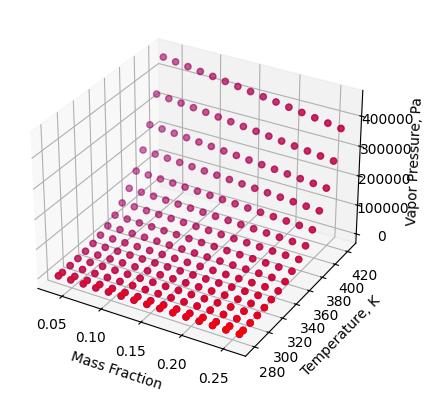

In [10]:
# define a function for the model with estimated thetas
def est(x, T):
    est = ((theta['a0'] + theta['a1']*x + theta['a2']*x**2 + theta['a3']*x**3 + theta['a4']*x**4)
        + (theta['b0'] + theta['b1']*x + theta['b2']*x**2 + theta['b3']*x**3 + theta['b4']*x**4)*T
        + (theta['c0'] + theta['c1']*x + theta['c2']*x**2 + theta['c3']*x**3 + theta['c4']*x**4)*T**2
        + (theta['d0'] + theta['d1']*x + theta['d2']*x**2 + theta['d3']*x**3 + theta['d4']*x**4)*T**3
        + (theta['e0'] + theta['e1']*x + theta['e2']*x**2 + theta['e3']*x**3 + theta['e4']*x**4)*T**4
)
    return est

# uncommenting the next line makes figure interactive but may need to pip install ipympl
# %matplotlib ipympl 

# plot the results
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(data_formatted.Comp, data_formatted.Temp, data_formatted.PropData, color='b') # experimental data
ax.scatter(data_formatted.Comp, data_formatted.Temp, est(data_formatted.Comp,data_formatted.Temp), color='r') # parmest fit
ax.set_xlabel('Mass Fraction')
ax.set_ylabel('Temperature, K')
ax.set_zlabel('Vapor Pressure, Pa')
plt.show()